In [1]:
import requests 
import json 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import time
from glob import glob
import numpy as np
import os

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def gfun_df(nname, df, tgt_col, gb, f, cond=[], tgt_arr=[]):
    df[nname] = np.nan
    if 0 < len(tgt_arr):
        df[tgt_col] = tgt_arr
    if len(cond) > 0:
        df.loc[cond, nname] = df[cond].groupby(gb)[tgt_col].transform(f)
    else:
        df[nname] = df.groupby(gb)[tgt_col].transform(f)
    return None

In [4]:
def long2wide(df, factorname, date_var = "date", id_var = "symbol"):
    df_wide = df[[date_var, id_var, factorname]].groupby([date_var, id_var], as_index = False).sum().pivot(date_var, id_var).replace(0, np.nan)
    df_wide.columns = [col[1] for col in df_wide.columns]
    return df_wide

In [5]:
def wide2long(wide, value_name):
    long = wide.unstack().reset_index()
    long.columns = ['symbol', 'date', value_name]
    return long

In [6]:
def xrank(list_pandas, n):
    if all(list_pandas.isnull()):
        return list_pandas
    return pd.qcut(list_pandas, n, labels=False)

In [7]:
def rerank(list_pandas):
    s = list_pandas.notnull().sum()
    return (list_pandas.round(6).rank() - 0.5 * (s + 1))/(0.5 * (s - 1))

In [8]:
def generateweight(list_pandas):
    wt_pos = list_pandas * (list_pandas > 0)
    wt_neg = list_pandas * (list_pandas < 0)
    iszero = (np.abs(list_pandas) < 1e-10)
    wt = wt_pos / np.abs(wt_pos).sum() + wt_neg / np.abs(wt_neg).sum()
    return (wt * (1 - iszero)).replace([np.inf, -np.inf, np.nan], 0)

In [9]:
def dollar_balance(alldata, wtcol):
    alldata['tmp'] = alldata[wtcol]
    alldata.loc[alldata.inuniv, 'tmp'] = alldata.loc[alldata.inuniv, 'tmp'].fillna(0)
    alldata.loc[~alldata.inuniv, 'tmp'] = np.nan
    alldata['hdg_wt'] = alldata.groupby('date')['tmp'].transform(np.nanmean)
    alldata[wtcol+'_db'] = alldata['tmp'] - alldata['hdg_wt']
    return alldata

In [10]:
def read_data(filepath):
    alldata = None
    for file in glob(filepath):
        print(file + '          ', end='\r')
        if file[-4:] != '.csv':
            continue
        tmp = pd.read_csv(file, index_col=0)
        if alldata is None:
            alldata = tmp
        else:
            alldata = pd.concat([alldata, tmp])
    return alldata.reset_index().rename(columns={'index':'date'})

In [11]:
def calcRets(alldata, rets=[1,2,3,5,10,15,20]):
    gfun_df('zperf', alldata, 'closePrice', 'symbol', lambda x: (x.shift(-1)-x)/x)
    for i in rets:
        gfun_df(f'fperf_{i}', alldata, 'closePrice', 'symbol', lambda x: (x.shift(-(i+1))-x.shift(-1))/x.shift(-1))
    for i in rets:
        gfun_df(f'bperf_{i}', alldata, 'closePrice', 'symbol', lambda x: (x-x.shift(i))/x.shift(i))
    return alldata

In [13]:
def enrich_alldata(asset_class='futures', frequency='hourly', univ_cnt=100, rets=[1,2,3,5,10,15,20], createuniv=True):
    if asset_class == 'futures':
        DATAPATH= r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\futures'
    elif asset_class == 'spot':
        DATAPATH_spot = r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\spot'
    else:
        raise ValueError('invald asset class!')
        return None
    if frequency == 'daily' or frequency == 'day':
        filepath = os.path.join(DATAPATH, 'daily\*')
        window = 90
    elif frequency == 'hourly' or frequency == 'hour':
        filepath = os.path.join(DATAPATH, 'hourly\*')
        window = 24 * 7
    elif frequency == 'minutely' or frequency == 'minute_bar' or frequency == 'minute':
        filepath = os.path.join(DATAPATH, 'minute_bar\*')
        window = 60 * 2
    else:
        raise ValueError('invalid frequency!')
        return None
    
    alldata = read_data(filepath)
    print('Calculating returns...')
#     alldata = calcRets(alldata, rets)
#     print('Calculating factors...')
#     alldata['ones'] = 1
#     gfun_df(f'vol', alldata, 'bperf_1', 'symbol', lambda x: x.rolling(window=window).std())
#     print('vol done.')
#     alldata['usd_volume'] = alldata['closePrice'] * alldata['volume']
#     gfun_df(f'adv', alldata, 'usd_volume', 'symbol', lambda x: x.rolling(window=window).mean())
#     print('adv done.')
#     if createuniv:
#         print('Creating universe...')
#         gfun_df('adv_rnk', alldata, f'adv', 'date', lambda x: x.rank()) 
#         alldata['cnt'] = alldata.groupby('date')['ones'].transform(sum)
#         alldata['adv_rnk_dec'] = alldata['cnt'] + 1 - alldata['adv_rnk']
#         alldata['inuniv'] = (alldata['adv_rnk_dec'] <= univ_cnt)
#     else:
#         alldata_hourly = pd.read_hdf(r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\futures\alldata_hourly.hdf')
#     alldata = pd.merge(alldata, alldata[alldata.inuniv].groupby('date')['adv'].sum().rename('adv_sum').reset_index(), how = 'left')
#     alldata['adv_zperf'] = alldata['adv'] * alldata['zperf'] / alldata['adv_sum'] * alldata['inuniv']
#     alldata['zperf_market'] = alldata.groupby('date')['adv_zperf'].transform(sum)
#     del alldata['adv_sum']
#     del alldata['adv_zperf']
    return alldata

In [ ]:
alldata = enrich_alldata(frequency='minute_bar', rets=[1,2,3,5,10,15,20,30,60])

In [38]:
gfun_df('adv_rnk', alldata, f'adv', 'date', lambda x: x.rank()) 

In [39]:
alldata['cnt'] = alldata.groupby('date')['ones'].transform(sum)

In [40]:
alldata['adv_rnk_dec'] = alldata['cnt'] + 1 - alldata['adv_rnk']

In [43]:
univ_cnt = 100

In [44]:
alldata['inuniv'] = (alldata['adv_rnk_dec'] <= univ_cnt)

In [56]:
alldata.columns

Index(['date', 'symbol', 'startTime', 'openPrice', 'highPrice', 'lowPrice',
       'closePrice', 'volume', 'turnover', 'zperf', 'fperf_1', 'fperf_2',
       'fperf_3', 'fperf_5', 'fperf_10', 'fperf_15', 'fperf_20', 'fperf_30',
       'fperf_60', 'bperf_1', 'bperf_2', 'bperf_3', 'bperf_5', 'bperf_10',
       'bperf_15', 'bperf_20', 'bperf_30', 'bperf_60', 'ones', 'vol',
       'usd_volume', 'adv', 'day', 'hour', 'adv_rnk', 'cnt', 'adv_rnk_dec',
       'inuniv'],
      dtype='object')

In [58]:
alldata = alldata.drop(columns = ['openPrice', 'highPrice', 'lowPrice', 'zperf', 'fperf_1', 'fperf_2',
       'fperf_3', 'fperf_5', 'fperf_10', 'fperf_15', 'fperf_20', 'fperf_30',
       'fperf_60', 'bperf_1', 'bperf_2', 'bperf_3', 'bperf_5', 'bperf_10',
       'bperf_15', 'bperf_20', 'bperf_30', 'bperf_60', 'ones', 'vol',
       'usd_volume', 'adv', 'day', 'hour', 'adv_rnk', 'cnt', 'adv_rnk_dec'])

In [63]:
alldata

,date,symbol,closePrice,volume,turnover,inuniv
0,2022-01-24 12:33:00,10000NFTUSDT,0.017800,630.0,11.21400,False
1,2022-01-24 12:34:00,10000NFTUSDT,0.017725,530.0,9.40925,False
2,2022-01-24 12:35:00,10000NFTUSDT,0.017745,9580.0,169.72065,False
3,2022-01-24 12:36:00,10000NFTUSDT,0.017750,18400.0,326.54525,False
4,2022-01-24 12:37:00,10000NFTUSDT,0.017730,4710.0,83.51205,False


In [64]:
alldata.to_hdf(r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\futures\alldata_minute_bar_cpvinfo.hdf', key='wmlakefund')

In [65]:
alldata.head()

,date,symbol,closePrice,volume,turnover,inuniv
0,2022-01-24 12:33:00,10000NFTUSDT,0.017800,630.0,11.21400,False
1,2022-01-24 12:34:00,10000NFTUSDT,0.017725,530.0,9.40925,False
2,2022-01-24 12:35:00,10000NFTUSDT,0.017745,9580.0,169.72065,False
3,2022-01-24 12:36:00,10000NFTUSDT,0.017750,18400.0,326.54525,False
4,2022-01-24 12:37:00,10000NFTUSDT,0.017730,4710.0,83.51205,False


In [68]:
alldata['minute'] = pd.to_datetime(alldata.date).dt.minute

In [69]:
alldata.head()

,date,symbol,closePrice,volume,turnover,inuniv,minute
0,2022-01-24 12:33:00,10000NFTUSDT,0.017800,630.0,11.21400,False,33
1,2022-01-24 12:34:00,10000NFTUSDT,0.017725,530.0,9.40925,False,34
2,2022-01-24 12:35:00,10000NFTUSDT,0.017745,9580.0,169.72065,False,35
3,2022-01-24 12:36:00,10000NFTUSDT,0.017750,18400.0,326.54525,False,36
4,2022-01-24 12:37:00,10000NFTUSDT,0.017730,4710.0,83.51205,False,37


In [70]:
alldata['volume_price'] = alldata['volume'] * alldata['closePrice']

In [83]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.rolling(window=60).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.rolling(window=60).sum(), cond=(alldata['minute']==0))
alldata['vwap_1h'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [75]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.shift(30).rolling(window=30).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.shift(30).rolling(window=30).sum(), cond=(alldata['minute']==0))
alldata['vwap_30m'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [76]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.shift(40).rolling(window=20).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.shift(40).rolling(window=20).sum(), cond=(alldata['minute']==0))
alldata['vwap_20m'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [77]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.shift(45).rolling(window=15).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.shift(45).rolling(window=15).sum(), cond=(alldata['minute']==0))
alldata['vwap_15m'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [78]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.shift(50).rolling(window=10).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.shift(50).rolling(window=10).sum(), cond=(alldata['minute']==0))
alldata['vwap_10m'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [79]:
gfun_df('volume_sum', alldata, 'volume', 'symbol', lambda x: x.shift(55).rolling(window=5).sum(), cond=(alldata['minute']==0))
gfun_df('volume_price_sum', alldata, 'volume_price', 'symbol', lambda x: x.shift(55).rolling(window=5).sum(), cond=(alldata['minute']==0))
alldata['vwap_5m'] = alldata['volume_price_sum'] / alldata['volume_sum']

In [80]:
gfun_df('close_1m', alldata, 'closePrice', 'symbol', lambda x: x.shift(59), cond=(alldata['minute']==0))

In [84]:
alldata_hourly2 = alldata[alldata['vwap_1h'].notnull()][['date', 'symbol', 'vwap_1h', 'vwap_30m', 'vwap_20m', 'vwap_15m', 'vwap_10m', 'vwap_5m', 'close_1m']]

In [86]:
alldata_hourly2.to_hdf(r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\futures\alldata_hourly2.hdf', key='wmlakefund')

In [91]:
alldata.iloc[-1:-990]

,date,symbol,closePrice,volume,turnover,inuniv,minute,volume_price,volume_sum,volume_price_sum,vwap_30m,vwap_20m,vwap_15m,vwap_10m,vwap_5m,close_1m,vwap_1h
39410626,2022-11-19,ZENUSDT,9.40,18326.3,174446.525,False,0,172267.220,1928362.0,2.411526e+07,13.354878,13.808837,13.915147,13.905471,13.746194,13.30,12.505569
39410627,2022-11-20,ZENUSDT,8.75,52893.7,482951.220,False,0,462819.875,1926506.2,2.384992e+07,13.331617,13.792732,13.997118,14.037152,14.054875,14.20,12.379880
39410628,2022-11-21,ZENUSDT,8.65,66312.8,570012.170,False,0,573605.720,1969332.3,2.409001e+07,13.293649,13.726342,13.966967,13.975419,14.024402,14.10,12.232578
39410629,2022-11-22,ZENUSDT,9.35,62193.6,561811.725,False,0,581510.160,2007964.0,2.433930e+07,13.261832,13.588173,13.939849,13.965969,13.991845,14.05,12.121381
39410630,2022-11-23,ZENUSDT,9.60,49523.0,477177.770,False,0,475420.800,2042563.0,2.460504e+07,13.236828,13.497887,13.918339,13.990705,13.987655,13.80,12.046158
39410631,2022-11-24,ZENUSDT,9.30,20351.4,193988.895,False,0,189268.020,2046184.4,2.456343e+07,13.223643,13.452952,13.831474,13.999096,14.033695,14.05,12.004505
39410632,2022-11-25,ZENUSDT,9.25,12322.2,113144.965,False,0,113980.350,2030826.7,2.428851e+07,13.205418,13.399835,13.716898,13.973344,14.024504,14.05,11.959912
39410633,2022-11-26,ZENUSDT,9.65,44929.4,432784.230,False,0,433568.710,2041282.2,2.423772e+07,13.171525,13.337493,13.626352,13.938765,13.932138,13.95,11.873771
39410634,2022-11-27,ZENUSDT,9.55,14080.2,136806.545,False,0,134465.910,2024943.4,2.394784e+07,13.153775,13.275574,13.452647,13.910754,13.940403,14.00,11.826424
39410635,2022-11-28,ZENUSDT,9.55,16406.3,154711.415,False,0,156680.165,2008141.7,2.363961e+07,13.139404,13.170128,13.307798,13.869413,13.994334,14.10,11.771882


In [88]:
alldata_hourly2.tail()

,date,symbol,vwap_1h,vwap_30m,vwap_20m,vwap_15m,vwap_10m,vwap_5m,close_1m
39411621,2023-04-20,ZRXUSDT,0.290411,0.258150,0.267425,0.278699,0.285883,0.273098,0.2763
39411622,2023-04-21,ZRXUSDT,0.290185,0.257040,0.265100,0.277477,0.284511,0.272010,0.2674
39411623,2023-04-22,ZRXUSDT,0.290035,0.256692,0.263420,0.276341,0.281883,0.272156,0.2632
39411624,2023-04-23,ZRXUSDT,0.289887,0.256307,0.262406,0.273711,0.280958,0.271979,0.2777
39411625,2023-04-24,ZRXUSDT,0.289877,0.254827,0.260048,0.269738,0.280474,0.268256,0.2676


In [16]:
alldata_hourly = pd.read_hdf(r'C:\Users\Administrator\Documents\jupyter_notebook\data\v5\futures\alldata_hourly.hdf')

In [32]:
alldata['day'] = pd.to_datetime(alldata['date']).dt.date

In [33]:
alldata['hour'] = pd.to_datetime(alldata['date']).dt.hour

In [35]:
alldata_hourly['day'] = pd.to_datetime(alldata_hourly['date']).dt.date
alldata_hourly['hour'] = pd.to_datetime(alldata_hourly['date']).dt.date

In [37]:
alldata = pd.merge(alldata, alldata_hourly[['day', 'hour', 'symbol', 'inuniv']], ['day', 'hour', 'symbol'])

TypeError: unhashable type: 'list'

In [20]:
alldata.head(10)

,date,symbol,startTime,openPrice,highPrice,lowPrice,closePrice,volume,turnover,zperf,...,bperf_5,bperf_10,bperf_15,bperf_20,bperf_30,bperf_60,ones,vol,usd_volume,adv
0,2022-01-24 12:33:00,10000NFTUSDT,1643027580000,0.017800,0.017800,0.017800,0.017800,630.0,11.21400,-0.004213,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11.21400,NaN
1,2022-01-24 12:34:00,10000NFTUSDT,1643027640000,0.017800,0.017800,0.017725,0.017725,530.0,9.40925,0.001128,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,9.39425,NaN
2,2022-01-24 12:35:00,10000NFTUSDT,1643027700000,0.017725,0.017780,0.017715,0.017745,9580.0,169.72065,0.000282,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,169.99710,NaN
3,2022-01-24 12:36:00,10000NFTUSDT,1643027760000,0.017745,0.017760,0.017740,0.017750,18400.0,326.54525,-0.001127,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,326.60000,NaN
4,2022-01-24 12:37:00,10000NFTUSDT,1643027820000,0.017750,0.017750,0.017730,0.017730,4710.0,83.51205,0.001974,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,83.50830,NaN
5,2022-01-24 12:38:00,10000NFTUSDT,1643027880000,0.017730,0.017785,0.017730,0.017765,11790.0,209.68100,-0.000563,...,-0.001966,NaN,NaN,NaN,NaN,NaN,1,NaN,209.44935,NaN
6,2022-01-24 12:39:00,10000NFTUSDT,1643027940000,0.017765,0.017815,0.017730,0.017755,10950.0,194.43305,-0.006477,...,0.001693,NaN,NaN,NaN,NaN,NaN,1,NaN,194.41725,NaN
7,2022-01-24 12:40:00,10000NFTUSDT,1643028000000,0.017755,0.017755,0.017640,0.017640,17800.0,314.68055,0.000283,...,-0.005917,NaN,NaN,NaN,NaN,NaN,1,NaN,313.99200,NaN
8,2022-01-24 12:41:00,10000NFTUSDT,1643028060000,0.017640,0.017670,0.017640,0.017645,11940.0,210.97130,-0.003684,...,-0.005915,NaN,NaN,NaN,NaN,NaN,1,NaN,210.68130,NaN
9,2022-01-24 12:42:00,10000NFTUSDT,1643028120000,0.017645,0.017685,0.017580,0.017580,340.0,5.99715,0.003982,...,-0.008460,NaN,NaN,NaN,NaN,NaN,1,NaN,5.97720,NaN


In [15]:
import statsmodels.api as sm

In [16]:
def getIC(alldata, wtcol, retcol='fperf_1', absret=False):
    gfun_df(f'alpha_{wtcol}', alldata, wtcol, 'date', lambda x: rerank(x), cond=alldata.inuniv)
    if absret:
        alldata[f'abs_{retcol}'] = np.abs(alldata[retcol])
        ic = alldata[[f'alpha_{wtcol}', f'abs_{retcol}']].corr().iloc[0,1]
        del alldata[f'abs_{retcol}']
    else:
        ic = alldata[[f'alpha_{wtcol}', retcol]].corr().iloc[0,1]
    del alldata[f'alpha_{wtcol}']
    return ic

In [17]:
getIC(alldata, 'vol', 'zperf', absret=True)

0.20171320870100407

In [19]:
getIC(alldata, 'bperf_24', 'zperf', absret=True)

0.064797787554132

In [20]:
gfun_df(f'volume24', alldata, 'volume', 'symbol', lambda x: x.rolling(window=24).mean())

In [21]:
getIC(alldata, 'volume24', 'zperf', absret=True)

0.06838036383951884

In [22]:
alldata['illiq'] = np.abs(alldata['bperf_1']) / alldata['vol'] / alldata['volume']
gfun_df(f'illiq24', alldata, 'illiq', 'symbol', lambda x: x.rolling(window=24).mean())

In [23]:
alldata['illiq_usd'] = np.abs(alldata['bperf_1']) / alldata['vol'] / alldata['usd_volume']
gfun_df(f'illiq24_usd', alldata, 'illiq_usd', 'symbol', lambda x: x.rolling(window=24).mean())

In [24]:
getIC(alldata, 'illiq24', 'zperf', absret=True)

-0.06048104998472303

In [102]:
riskfactors = alldata[['date', 'symbol', 'vol', 'bperf_24', 'volume24', 'illiq24', 'zperf']]

In [103]:
riskfactors = riskfactors.loc[riskfactors.date>'2022'].sort_values(by = ['date']).set_index('date')

In [100]:
def neutral(df):
    resret = None
    print("Start neutralization...")
    for i in range(len(df.index)):
        print("Doing " + str(i+1) + "/" + str(len(df.index)), end = "\r")
        try:
            dfi = df.loc[df.index[i]].reset_index().drop(columns='date').set_index('symbol')
            model = sm.OLS(dfi.iloc[:,-1], sm.add_constant(dfi.iloc[:,:-1]), missing = "drop")
            results = sm.add_constant(dfi.iloc[:,:-1]).dot(model.fit().params)
            res = dfi.iloc[:,-1] - results
            res = res.rename('szperf').reset_index()
            res['date'] = df.index[i]
            if resret is None:
                resrest = res
            else:
                resret = pd.concat([resret, res])
        except Exception as e:
            print(e, "\n")
    print("Neutralization completed")
    return resret

In [ ]:
szperf = neutral(riskfactors.iloc[:5000])

Start neutralization...


In [405]:
alldata['szperf_market'] = alldata['zperf'] - alldata['zperf_market']

In [256]:
alldata = enrich_alldata(asset_class='futures', frequency='hourly')

In [278]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['bperf_20']/alldata['vol'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5])

,mygroup,cnt,vol,adv,0,1,2,3,5
0,0.0,212228,0.010175,129283.677635,0.000095,-0.000002,-0.000178,-0.000355,-3.232201e-04
1,1.0,212227,0.010567,144774.794206,-0.000059,-0.000010,-0.000098,-0.000141,-6.693473e-07
2,2.0,212227,0.010599,144539.557325,-0.000194,-0.000141,-0.000205,-0.000390,-3.362163e-04
3,3.0,212227,0.010533,141171.596615,-0.000213,-0.000236,-0.000460,-0.000683,-8.199865e-04
4,4.0,212227,0.010459,137069.157632,-0.000126,-0.000192,-0.000459,-0.000671,-9.002074e-04
5,5.0,212227,0.010334,126991.515906,0.000010,-0.000045,-0.000197,-0.000291,-5.287066e-04
6,6.0,212227,0.010329,124038.475539,0.000078,0.000050,0.000083,0.000085,-1.334780e-04
7,7.0,212227,0.010196,121159.226315,0.000072,0.000047,0.000178,0.000336,1.869243e-04
8,8.0,212227,0.010084,121842.528272,0.000065,0.000084,0.000292,0.000457,3.959128e-04
9,9.0,212227,0.010250,147052.878696,-0.000077,0.000098,0.000304,0.000480,3.903306e-04


In [279]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['bperf_3']/alldata['vol'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5])

,mygroup,cnt,vol,adv,0,1,2,3,5
0,0.0,212228,0.010215,127641.308397,0.000433,0.000309,2.548398e-04,0.000143,0.000231
1,1.0,212227,0.010378,137859.853936,0.000240,-0.000016,-1.515059e-07,0.000002,0.000187
2,2.0,212227,0.010459,140133.377128,0.000062,-0.000044,1.075217e-05,-0.000108,-0.000107
3,3.0,212227,0.010547,140748.431497,-0.000015,-0.000096,-8.224983e-05,-0.000226,-0.000348
4,4.0,244836,0.010299,115577.232147,-0.000034,-0.000135,-2.120811e-04,-0.000283,-0.000573
5,5.0,179618,0.010843,175374.036718,-0.000098,-0.000158,-2.952320e-04,-0.000378,-0.000593
6,6.0,212227,0.010359,133454.280204,-0.000151,-0.000154,-3.376719e-04,-0.000445,-0.000603
7,7.0,212227,0.010265,127966.366063,-0.000204,-0.000034,-1.640319e-04,-0.000207,-0.000331
8,8.0,212227,0.010101,121970.776772,-0.000242,-0.000033,-9.588430e-05,-0.000055,-0.000229
9,9.0,212227,0.010150,129324.026798,-0.000351,0.000011,1.701972e-04,0.000369,0.000294


In [259]:
gfun_df('alpha_bperf_3', alldata, 'tmp', 'date', lambda x: rerank(x), tgt_arr=alldata['bperf_3']/alldata['vol'], cond=alldata.inuniv)

In [260]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['alpha_bperf_3'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5])

,mygroup,cnt,vol,med_adv,min_adv,max_adv,med_alpha_bperf_3,min_alpha_bperf_3,max_alpha_bperf_3,0,1,2,3,5
0,0.0,134846,0.011873,352487.650947,7775.351263,3.490900e+08,-0.918367,-1.000000,-0.816327,0.000344,0.000033,-0.000008,-0.000090,-0.000280
1,1.0,135293,0.011339,348106.937933,7390.292890,3.455705e+08,-0.711340,-0.815789,-0.608247,0.000177,-0.000046,-0.000119,-0.000176,-0.000297
2,2.0,135622,0.011098,365155.644672,7410.717415,3.375595e+08,-0.505155,-0.607843,-0.408163,0.000080,-0.000002,-0.000035,-0.000093,-0.000206
3,3.0,134075,0.010947,358020.024026,7467.110719,3.406787e+08,-0.304348,-0.407407,-0.204082,0.000031,-0.000074,-0.000119,-0.000198,-0.000353
4,4.0,138799,0.010906,370341.928670,7493.263130,3.449618e+08,-0.094340,-0.202020,0.000000,-0.000052,-0.000036,-0.000086,-0.000147,-0.000239
5,5.0,131683,0.010814,350268.448815,7380.478907,3.499318e+08,0.106383,0.010101,0.204082,-0.000114,-0.000062,-0.000159,-0.000220,-0.000362
6,6.0,133942,0.010824,348275.556568,7455.346504,3.485719e+08,0.306122,0.204301,0.408163,-0.000141,-0.000061,-0.000143,-0.000184,-0.000284
7,7.0,133343,0.010896,348991.161913,7420.202862,3.385484e+08,0.510204,0.408451,0.608247,-0.000206,-0.000085,-0.000085,-0.000103,-0.000201
8,8.0,137560,0.011045,326953.108475,7369.163771,3.469926e+08,0.714286,0.608696,0.816327,-0.000282,-0.000078,-0.000146,-0.000218,-0.000344
9,9.0,131648,0.011829,364313.540725,7375.365981,3.492313e+08,0.918367,0.817204,1.000000,-0.000490,-0.000214,-0.000382,-0.000551,-0.000825


<AxesSubplot:xlabel='date'>

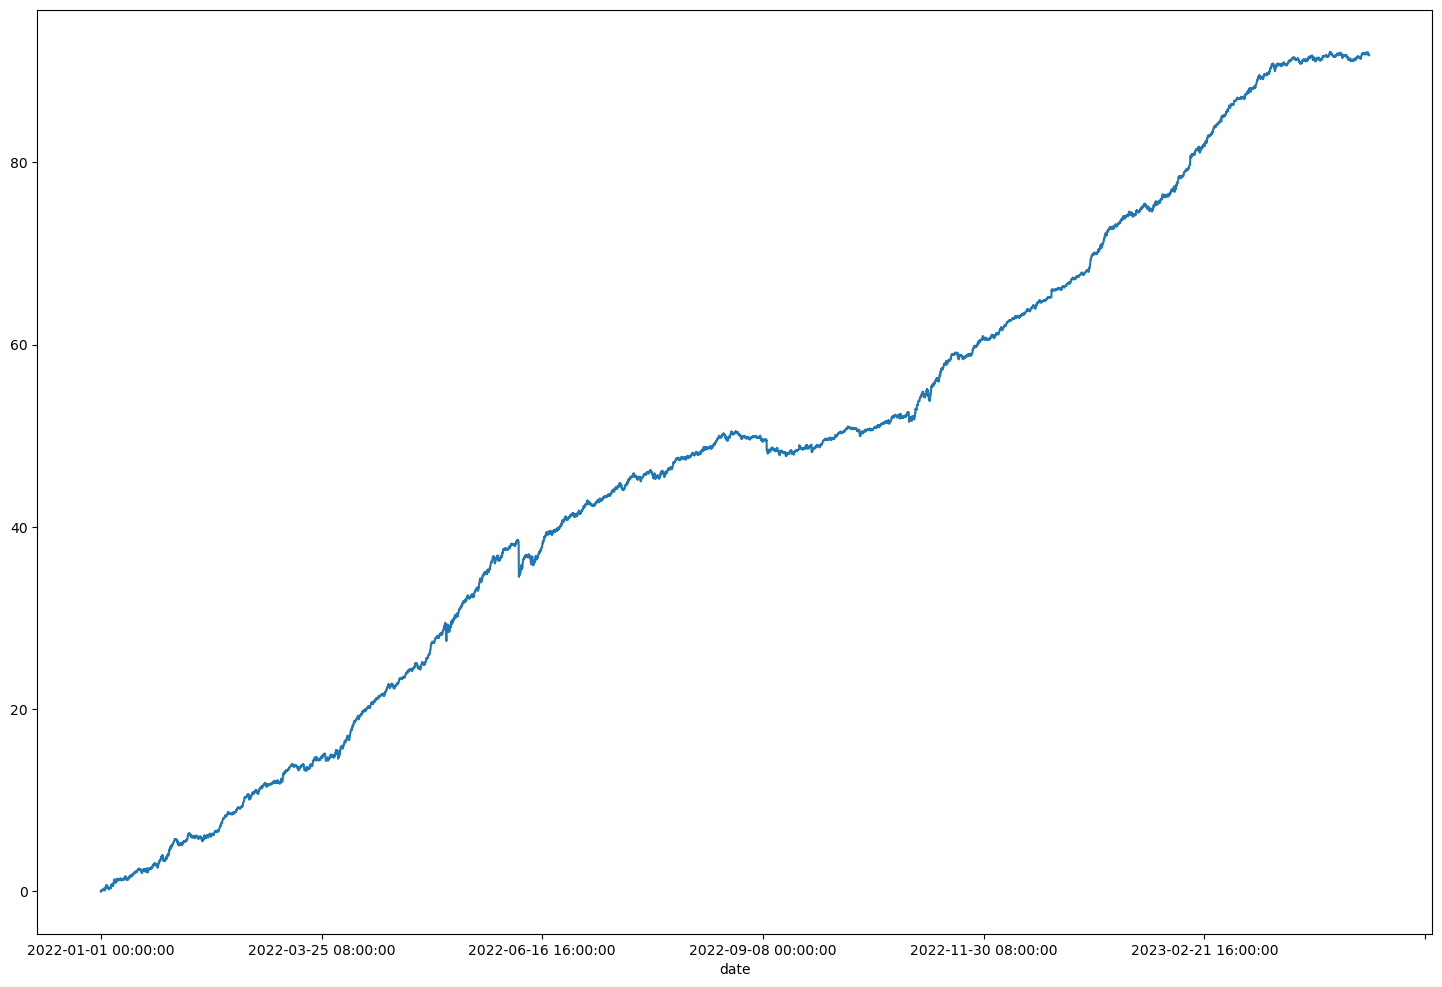

In [261]:
tfilters = (alldata.date > '2022') & alldata.inuniv & (alldata['alpha_bperf_3'].abs()>0.8)
alldata[tfilters].groupby('date').apply(lambda x: (-x['alpha_bperf_3']*x['zperf']).sum()).cumsum().plot(figsize=(18,12))

In [468]:
wtcol = 'sig'
ret_col='zperf'
sret_col=None
tcost=0

avg positive weight: 15.698455175900747
avg negative weight: -15.698455175900747


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,3.70,0.82,60.11,60.11,3.28,1.03,1.03
2021Q2,6.04,0.83,56.52,56.52,2.81,1.02,1.02
2021Q3,11.09,0.81,17.16,17.16,1.11,0.53,0.53
2021Q4,28.57,0.78,19.13,19.13,1.98,0.61,0.61
2022Q1,49.04,0.78,43.85,43.85,2.62,2.12,2.12
2022Q2,49.13,0.81,110.12,110.12,6.25,3.10,3.10
2022Q3,50.21,0.80,41.45,41.45,2.35,2.02,2.02
2022Q4,50.31,0.80,55.70,55.70,3.17,2.73,2.73
2023Q1,49.56,0.79,59.28,59.28,3.47,2.55,2.55


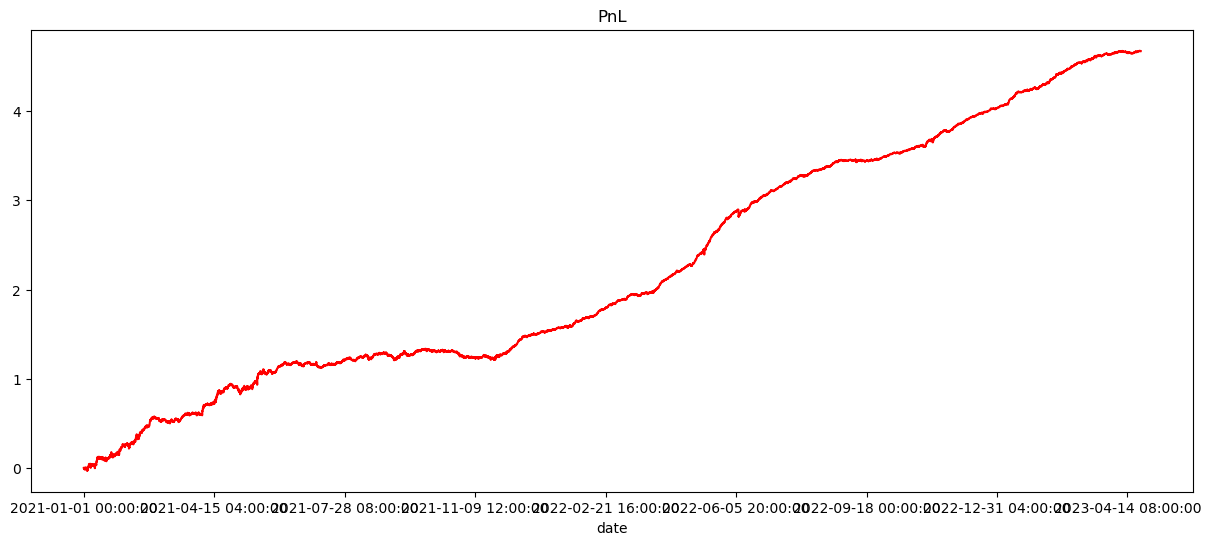

In [490]:
def pnldetails(alldata, wtcol, ret_col='zperf', sret_col=None, tcost=0, frequency='hourly'):
    if frequency == 'daily' or frequency == 'day':
        cnt = 252
    elif frequency == 'hourly' or frequency == 'hour':
        cnt = 24 * 252
    elif frequency == 'minutely' or frequency == 'minute_bar' or frequency == 'minute':
        cnt = 60 * 24 * 252
    alldata['tmp'] = alldata[wtcol]
    alldata[wtcol] = alldata[wtcol] * alldata.inuniv
    alldata['abs_wt'] = np.abs(alldata[wtcol])
    gfun_df('abs_wt_chg', alldata, wtcol, alldata.symbol, lambda x: np.abs(x.fillna(0).diff()))
    abs_wt_chg_interval = alldata.groupby('date')['abs_wt_chg'].sum().rename('abs_wt_chg')
    gmv_interval = alldata.groupby('date')['abs_wt'].sum().rename('gmv')
    gmv_interval = (gmv_interval + gmv_interval.shift(1)).replace(0,np.nan) / 2
    if not sret_col is None:
        alldata['spnl'] = alldata[wtcol] * alldata[sret_col]
        spnl_interval = alldata.groupby('date')['spnl'].sum().rename('spnl')
        spnl_interval_pct = (spnl_interval / gmv_interval.replace(0,np.nan)).rename('spnl(%)')
        spnl_interval_ac_pct = ((spnl_interval - abs_wt_chg_interval * tcost) / gmv_interval.replace(0,np.nan)).rename('spnl_ac(%)')
    alldata['pnl'] = alldata[wtcol] * alldata[ret_col]
    pnl_interval = alldata.groupby('date')['pnl'].sum().rename('pnl')
    pnl_interval_pct = (pnl_interval / gmv_interval.replace(0,np.nan)).rename('pnl(%)')
    pnl_interval_ac_pct = ((pnl_interval - abs_wt_chg_interval * tcost) / gmv_interval.replace(0,np.nan)).rename('pnl_ac(%)')

    turnover_interval = (abs_wt_chg_interval / gmv_interval).rename('turnover')
    if not sret_col is None:
        tab_interval = pd.concat([gmv_interval, turnover_interval, spnl_interval, spnl_interval_pct, spnl_interval_ac_pct, pnl_interval, pnl_interval_pct, pnl_interval_ac_pct, abs_wt_chg_interval], axis = 1)
    else:
        tab_interval = pd.concat([gmv_interval, turnover_interval, pnl_interval, pnl_interval_pct, pnl_interval_ac_pct, abs_wt_chg_interval], axis = 1)
    tab_interval.index = tab_interval.index.astype(str)
    tab_interval = tab_interval.reset_index()
    tab_interval = tab_interval[tab_interval['date'] > '2021']
    if not 'year' in tab_interval.columns:
        tab_interval['year'] = pd.to_datetime(tab_interval['date']).dt.year
    if not 'month' in tab_interval.columns:
        tab_interval['month'] = pd.to_datetime(tab_interval['date']).dt.month
    tab_interval['quarter'] = np.floor((tab_interval['month']-1)/3)+1
    tab_interval['quarter'] = tab_interval['quarter'].astype(int)
    tab_interval['YQ'] = tab_interval['year'].astype(str) + 'Q' + tab_interval['quarter'].astype(str)

    if not sret_col is None:
        tab_yq = pd.concat([tab_interval.groupby('YQ')[['gmv', 'turnover']].mean(), tab_interval.groupby('YQ')[['spnl(%)', 'pnl(%)', 'spnl_ac(%)', 'pnl_ac(%)']].sum() * 100], axis=1)
    else:
        tab_yq = pd.concat([tab_interval.groupby('YQ')[['gmv', 'turnover']].mean(), tab_interval.groupby('YQ')[['pnl(%)', 'pnl_ac(%)']].sum() * 100], axis=1)
    if not sret_col is None:
        tab_yq['sretptrade'] = tab_interval.groupby('YQ')['spnl'].sum() / tab_interval.groupby('YQ')['abs_wt_chg'].sum() * 1e4
        tab_yq['sSR'] = tab_interval.groupby('YQ')['spnl(%)'].mean() / tab_interval.groupby('YQ')['spnl(%)'].std() * np.sqrt(cnt)
        tab_yq['sSR_ac'] = tab_interval.groupby('YQ')['spnl_ac(%)'].mean() / tab_interval.groupby('YQ')['spnl_ac(%)'].std() * np.sqrt(cnt)
    tab_yq['retptrade'] = tab_interval.groupby('YQ')['pnl'].sum() / tab_interval.groupby('YQ')['abs_wt_chg'].sum() * 1e4
    tab_yq['SR'] = tab_interval.groupby('YQ')['pnl(%)'].mean() / tab_interval.groupby('YQ')['pnl(%)'].std() * np.sqrt(cnt)
    tab_yq['SR_ac'] = tab_interval.groupby('YQ')['pnl_ac(%)'].mean() / tab_interval.groupby('YQ')['pnl_ac(%)'].std() * np.sqrt(cnt)
    if not sret_col is None:
        tab_yq.loc['summary'] = [tab_interval['gmv'].mean(), 
                                   tab_interval['turnover'].mean(), 
                                   tab_interval['spnl(%)'].mean() * cnt * 100,
                                   tab_interval['pnl(%)'].mean() * cnt * 100, 
                                   tab_interval['spnl_ac(%)'].mean() * cnt * 100,
                                   tab_interval['pnl_ac(%)'].mean() * cnt * 100, 
                                   tab_interval['spnl'].sum() / tab_interval['abs_wt_chg'].sum() * 1e4,
                                   tab_interval['pnl'].sum() / tab_interval['abs_wt_chg'].sum() * 1e4,
                                   tab_interval['spnl(%)'].mean() / tab_interval['spnl(%)'].std() * np.sqrt(cnt),
                                   tab_interval['pnl(%)'].mean() / tab_interval['pnl(%)'].std() * np.sqrt(cnt),
                                   tab_interval['spnl_ac(%)'].mean() / tab_interval['spnl_ac(%)'].std() * np.sqrt(cnt),
                                   tab_interval['pnl_ac(%)'].mean() / tab_interval['pnl_ac(%)'].std() * np.sqrt(cnt)]
    else:
        tab_yq.loc['summary'] = [tab_interval['gmv'].mean(), 
                                   tab_interval['turnover'].mean(), 
                                   tab_interval['pnl(%)'].mean() * cnt * 100, 
                                   tab_interval['pnl_ac(%)'].mean() * cnt * 100, 
                                   tab_interval['pnl'].sum() / tab_interval['abs_wt_chg'].sum() * 1e4,
                                   tab_interval['pnl(%)'].mean() / tab_interval['pnl(%)'].std() * np.sqrt(cnt),
                                   tab_interval['pnl_ac(%)'].mean() / tab_interval['pnl_ac(%)'].std() * np.sqrt(cnt)]
    avg_pos_wt = (alldata[alldata[wtcol]>0].groupby('date')[wtcol].sum()).mean()
    avg_neg_wt = (alldata[alldata[wtcol]<0].groupby('date')[wtcol].sum()).mean()
    print(f'avg positive weight: {avg_pos_wt}')
    print(f'avg negative weight: {avg_neg_wt}')

    tab_yq = round(tab_yq.fillna(0), 2)
    display(HTML(tab_yq.to_html()))
    tab_interval = tab_interval.set_index('date')
    if not sret_col is None:
        tab_interval['fpnl(%)'] = tab_interval['pnl_ac(%)'] - tab_interval['spnl_ac(%)']
        tab_interval['pnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "red", figsize = (15,6))
        tab_interval['spnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "green", figsize = (15,6))
        tab_interval['fpnl(%)'].fillna(0).cumsum().plot(title = "PnL", color = "blue", figsize = (15,6))
        plt.gca().legend(("pnl_ac", "spnl_ac", "fpnl"))
    else:
        tab_interval['pnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "red", figsize = (15,6))
    return

In [496]:
alldata['sig1'] = -alldata['alpha_bperf_3']

avg positive weight: 15.698455175900747
avg negative weight: -15.698455175900747


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,3.70,0.82,60.11,60.11,3.28,5.06,5.06
2021Q2,6.04,0.83,56.52,56.52,2.81,5.01,5.01
2021Q3,11.09,0.81,17.16,17.16,1.11,2.60,2.60
2021Q4,28.57,0.78,19.13,19.13,1.98,2.99,2.99
2022Q1,49.04,0.78,43.85,43.85,2.62,10.39,10.39
2022Q2,49.13,0.81,110.12,110.12,6.25,15.16,15.16
2022Q3,50.21,0.80,41.45,41.45,2.35,9.90,9.90
2022Q4,50.31,0.80,55.70,55.70,3.17,13.37,13.37
2023Q1,49.56,0.79,59.28,59.28,3.47,12.48,12.48


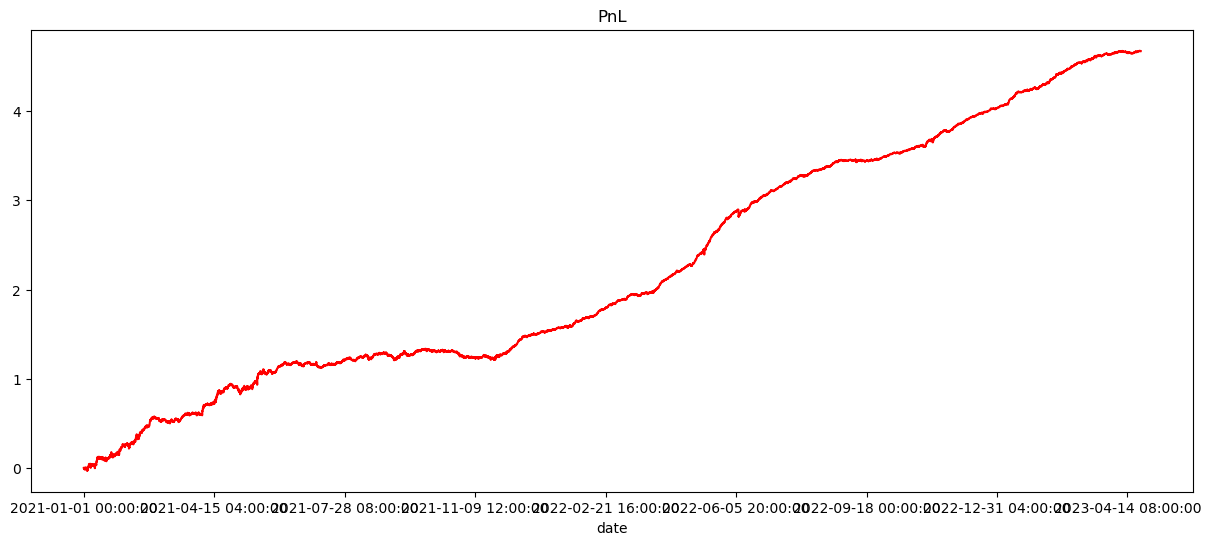

In [497]:
pnldetails(alldata, 'sig1')

In [498]:
alldata['sig2'] = -alldata['zperf_seas1'] / alldata['vol']

avg positive weight: 21.273077520110444
avg negative weight: -20.97943117732824


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,4.46,1.47,106.16,106.16,5.43,3.05,3.05
2021Q2,8.06,1.46,184.42,184.42,10.49,3.70,3.70
2021Q3,14.99,1.47,33.64,33.64,0.11,1.12,1.12
2021Q4,39.61,1.47,163.00,163.00,6.15,7.46,7.46
2022Q1,70.26,1.47,76.98,76.98,2.68,2.99,2.99
2022Q2,69.64,1.47,239.09,239.09,11.35,6.97,6.97
2022Q3,68.24,1.49,95.58,95.58,4.61,4.84,4.84
2022Q4,67.03,1.50,84.33,84.33,2.87,4.46,4.46
2023Q1,67.18,1.48,2.36,2.36,0.77,0.11,0.11


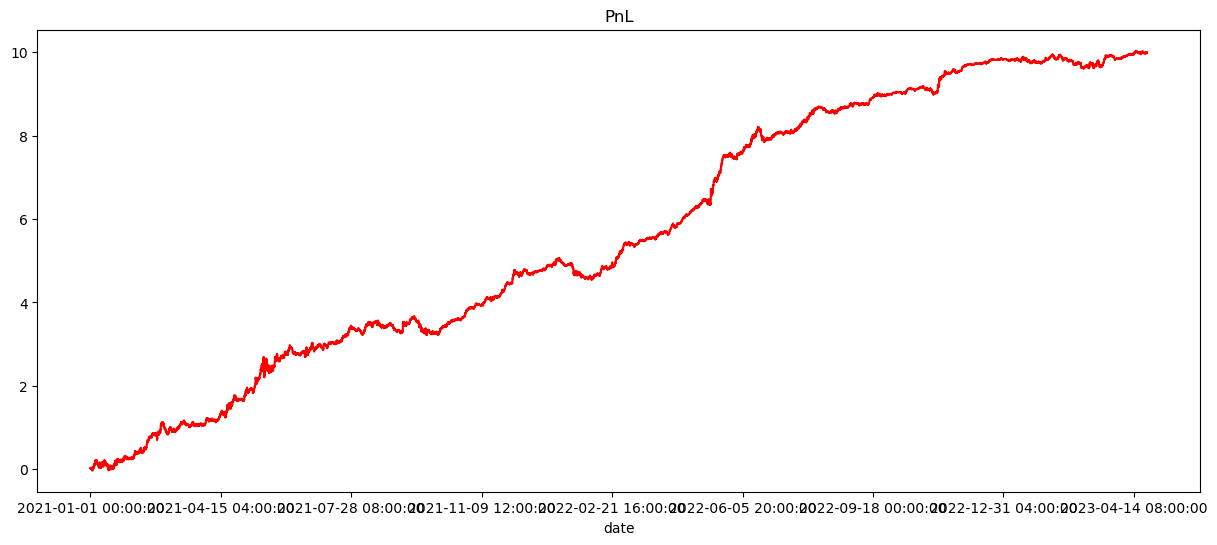

In [499]:
pnldetails(alldata, 'sig2')

avg positive weight: 51.92822998792154
avg negative weight: -51.83494165573357


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,11.83,1.01,111.95,111.95,5.46,5.74,5.74
2021Q2,19.84,0.99,157.96,157.96,8.29,5.96,5.96
2021Q3,36.38,0.99,26.12,26.12,0.89,1.66,1.66
2021Q4,94.18,0.97,93.30,93.30,5.29,7.64,7.64
2022Q1,162.77,0.97,77.41,77.41,3.60,5.35,5.35
2022Q2,162.91,0.99,232.87,232.87,11.62,11.97,11.97
2022Q3,165.59,0.98,87.54,87.54,4.56,8.70,8.70
2022Q4,165.99,0.98,85.22,85.22,4.08,8.96,8.96
2023Q1,163.21,0.98,60.16,60.16,3.01,5.43,5.43


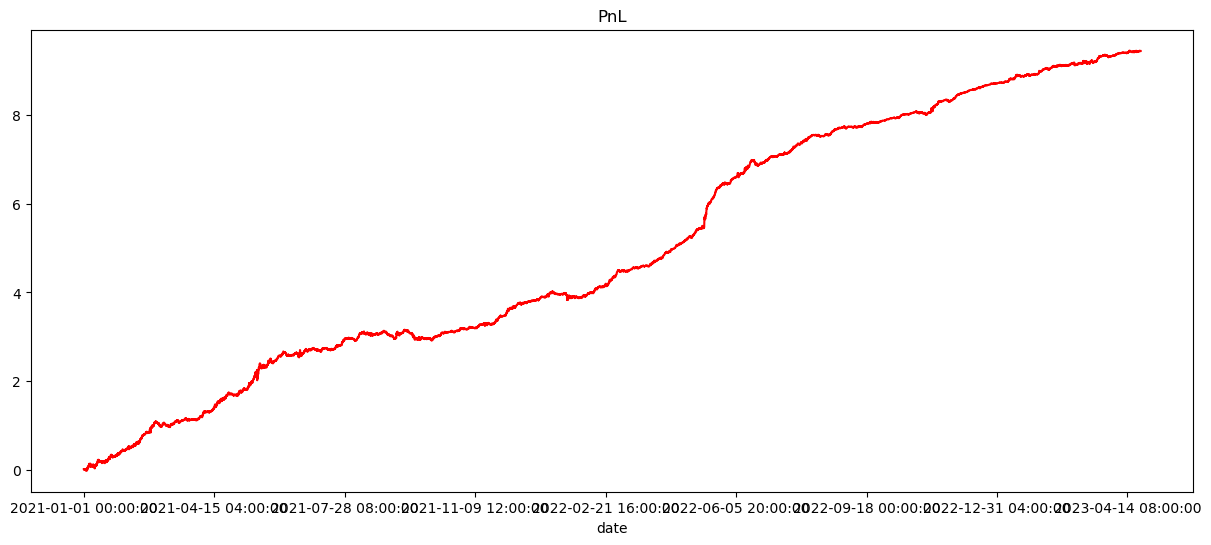

In [503]:
alldata['sig'] = 3 * alldata['sig1'] + alldata['sig2']
pnldetails(alldata, 'sig')

avg positive weight: 51.92822998792154
avg negative weight: -51.83494165573357


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,11.83,1.01,111.95,68.37,5.46,5.74,3.51
2021Q2,19.84,0.99,157.96,114.71,8.29,5.96,4.33
2021Q3,36.38,0.99,26.12,-17.50,0.89,1.66,-1.11
2021Q4,94.18,0.97,93.30,50.50,5.29,7.64,4.13
2022Q1,162.77,0.97,77.41,35.30,3.60,5.35,2.44
2022Q2,162.91,0.99,232.87,189.45,11.62,11.97,9.74
2022Q3,165.59,0.98,87.54,44.10,4.56,8.70,4.39
2022Q4,165.99,0.98,85.22,42.03,4.08,8.96,4.42
2023Q1,163.21,0.98,60.16,18.01,3.01,5.43,1.63


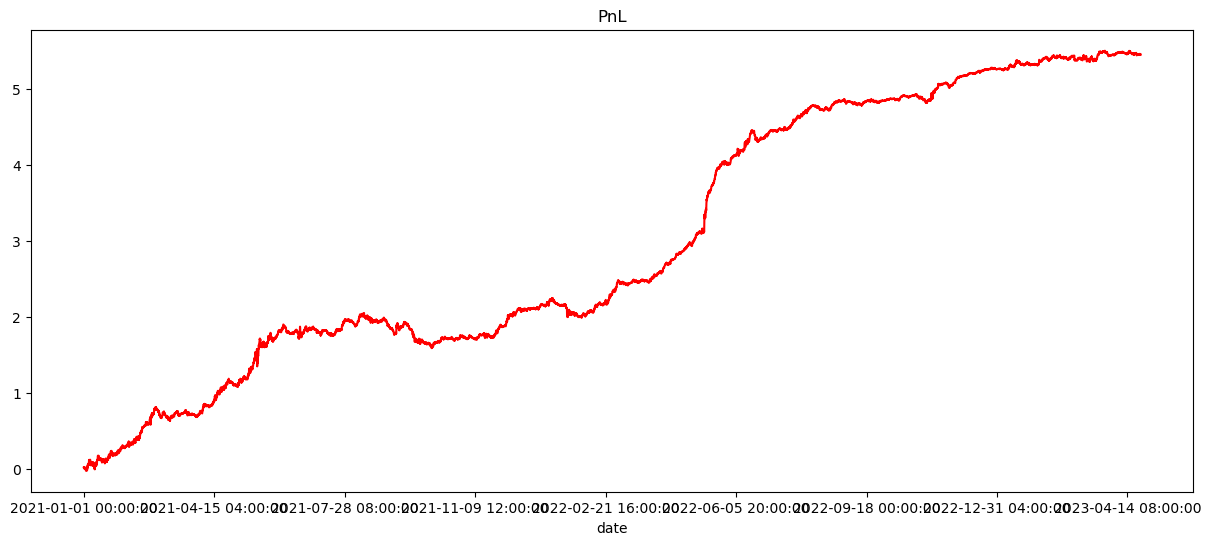

In [505]:
pnldetails(alldata, 'sig', tcost=2e-4)

In [334]:
alldata['zperf_seas30_vol'] = alldata['zperf_seas30'] / alldata['vol']

In [335]:
getIC(alldata, 'zperf_seas30_vol', 'zperf', absret=True)

0.011797643113447607

In [322]:
def seas30(x):
    res = x.shift(24)
    for i in range(2,31):
        res += x.shift(i*24)
    return res/30

In [323]:
gfun_df(f'zperf_seas30', alldata, 'zperf', 'symbol', lambda x: seas30(x))

In [324]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['zperf_seas30'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5,10,20])

,mygroup,cnt,vol,adv,med_zperf_seas30,min_zperf_seas30,max_zperf_seas30,0,1,2,3,5,10,20
0,0.0,200753,0.012133,138671.309783,-0.003722,-0.038094,-0.002749,-0.000010,0.000071,0.000245,0.000075,0.000192,0.000083,-0.000267
1,1.0,200753,0.010489,122869.225414,-0.002157,-0.002749,-0.001714,-0.000140,0.000143,0.000257,0.000276,0.000273,0.000098,-0.000458
2,2.0,200752,0.009917,119444.176750,-0.001350,-0.001714,-0.001032,-0.000199,-0.000012,0.000095,0.000146,0.000165,-0.000012,-0.000468
3,3.0,200753,0.009525,120506.603071,-0.000750,-0.001032,-0.000490,-0.000119,0.000028,0.000092,0.000155,0.000200,0.000026,-0.000416
4,4.0,200752,0.009161,112858.397823,-0.000248,-0.000490,-0.000020,-0.000047,0.000039,0.000028,0.000137,0.000155,0.000012,-0.000305
5,5.0,200753,0.009021,109275.350074,0.000198,-0.000020,0.000433,0.000012,-0.000026,-0.000119,-0.000072,-0.000052,-0.000276,-0.000616
6,6.0,200752,0.009393,125243.470562,0.000683,0.000433,0.000954,0.000020,0.000004,-0.000109,-0.000111,-0.000152,-0.000401,-0.000632
7,7.0,200753,0.009754,130174.508680,0.001257,0.000954,0.001611,0.000027,-0.000047,-0.000161,-0.000271,-0.000402,-0.000589,-0.000965
8,8.0,200752,0.010468,145449.897164,0.002046,0.001611,0.002645,0.000084,-0.000120,-0.000323,-0.000508,-0.000773,-0.000928,-0.001330
9,9.0,200753,0.012330,192735.669466,0.003651,0.002645,0.135213,0.000066,-0.000387,-0.000663,-0.000875,-0.001459,-0.001842,-0.002401


192236


<AxesSubplot:xlabel='date'>

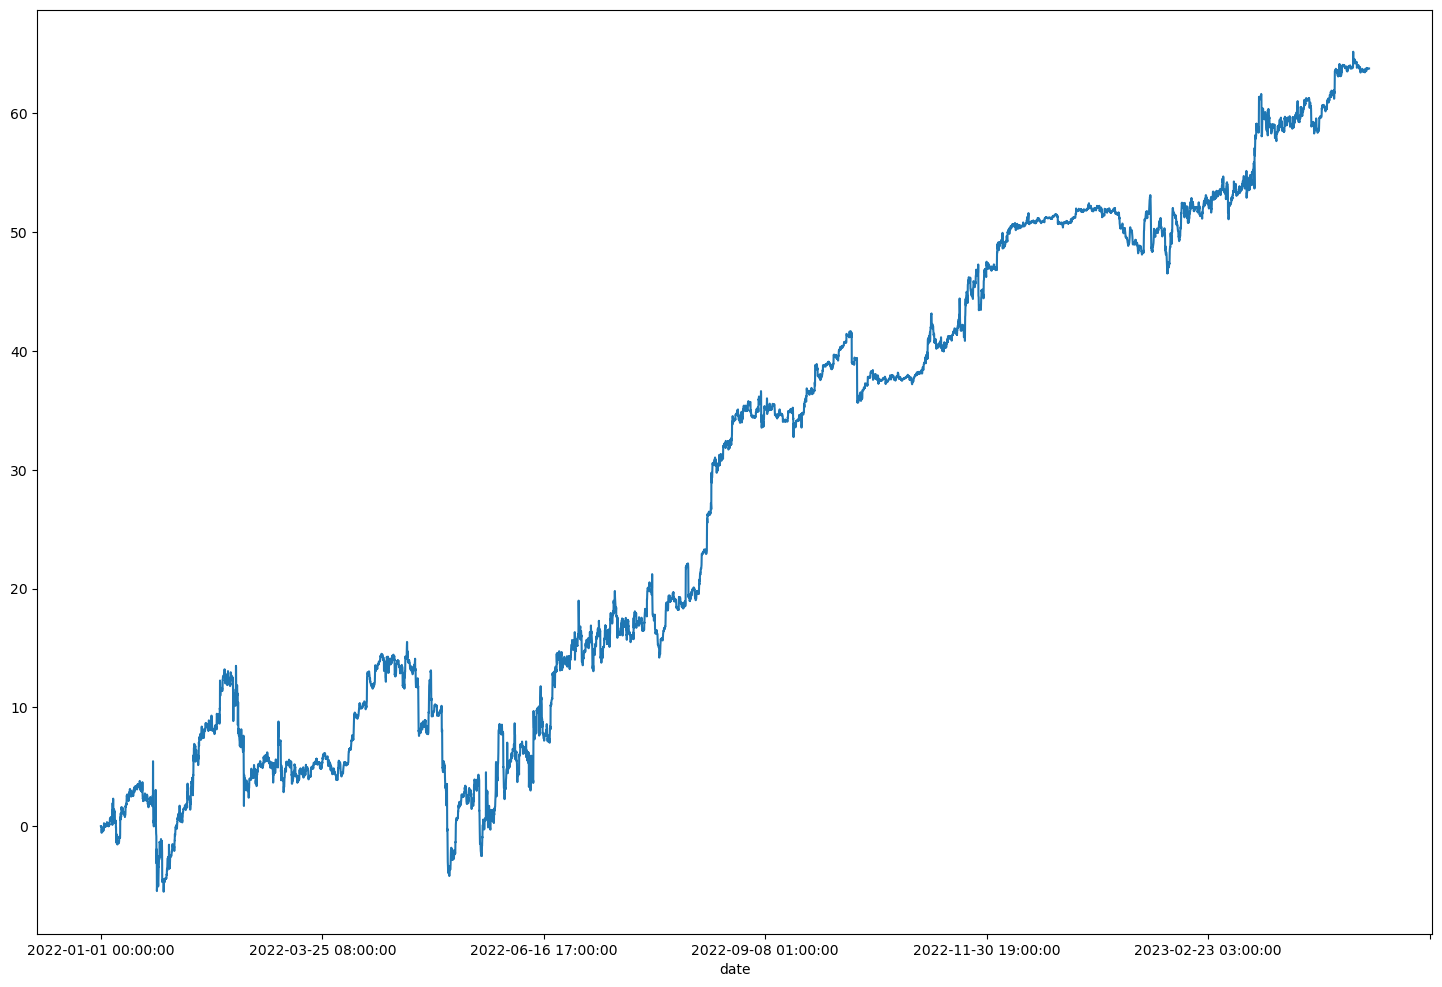

In [330]:
tfilters = (alldata.date > '2022') & alldata.inuniv & (alldata['zperf_seas30'].abs()>0.003)
print(sum(tfilters))
alldata[tfilters].groupby('date').apply(lambda x: (-x['zperf_seas30'] / x['vol'] * x['fperf_10']).sum()).cumsum().plot(figsize=(18,12))

In [286]:
gfun_df(f'zperf_seas1', alldata, 'zperf', 'symbol', lambda x: x.shift(24))
gfun_df(f'zperf_seas3', alldata, 'zperf', 'symbol', lambda x: (x.shift(24) + x.shift(48) + x.shift(72))/3)
gfun_df(f'zperf_seas5', alldata, 'zperf', 'symbol', lambda x: (x.shift(24) + x.shift(48) + x.shift(72) + x.shift(96) + x.shift(120))/5)

In [302]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['zperf_seas1'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5])

,mygroup,cnt,vol,adv,med_zperf_seas1,min_zperf_seas1,max_zperf_seas1,0,1,2,3,5
0,0.0,215237,0.013549,184326.502137,-0.018551,-0.994187,-0.012280,0.001076,0.000462,-0.000028,-0.000176,-0.000401
1,1.0,215237,0.011102,146909.236310,-0.009061,-0.012280,-0.006894,0.000276,0.000117,0.000047,0.000030,-0.000347
2,2.0,215238,0.009992,131472.281320,-0.005231,-0.006894,-0.003897,0.000070,0.000080,0.000057,0.000093,-0.000171
3,3.0,215242,0.009281,120119.430122,-0.002747,-0.003897,-0.001730,-0.000046,0.000074,0.000096,0.000157,0.000112
4,4.0,267772,0.008787,79865.426552,-0.000403,-0.001730,0.000000,-0.000074,0.000040,0.000085,0.000094,0.000127
5,5.0,162700,0.008863,147773.092883,0.001062,0.000008,0.001795,-0.000155,-0.000042,-0.000002,0.000005,-0.000024
6,6.0,215232,0.009234,116624.939917,0.002782,0.001795,0.003896,-0.000156,-0.000110,-0.000039,0.000025,0.000067
7,7.0,215235,0.009807,125963.099744,0.005173,0.003896,0.006745,-0.000229,-0.000145,-0.000127,-0.000131,-0.000078
8,8.0,215240,0.010894,140413.973851,0.008780,0.006745,0.011799,-0.000253,-0.000248,-0.000236,-0.000300,-0.000234
9,9.0,215234,0.013490,184900.243631,0.017689,0.011799,4.140044,-0.000896,-0.000615,-0.000654,-0.001052,-0.001262


309980


<AxesSubplot:xlabel='date'>

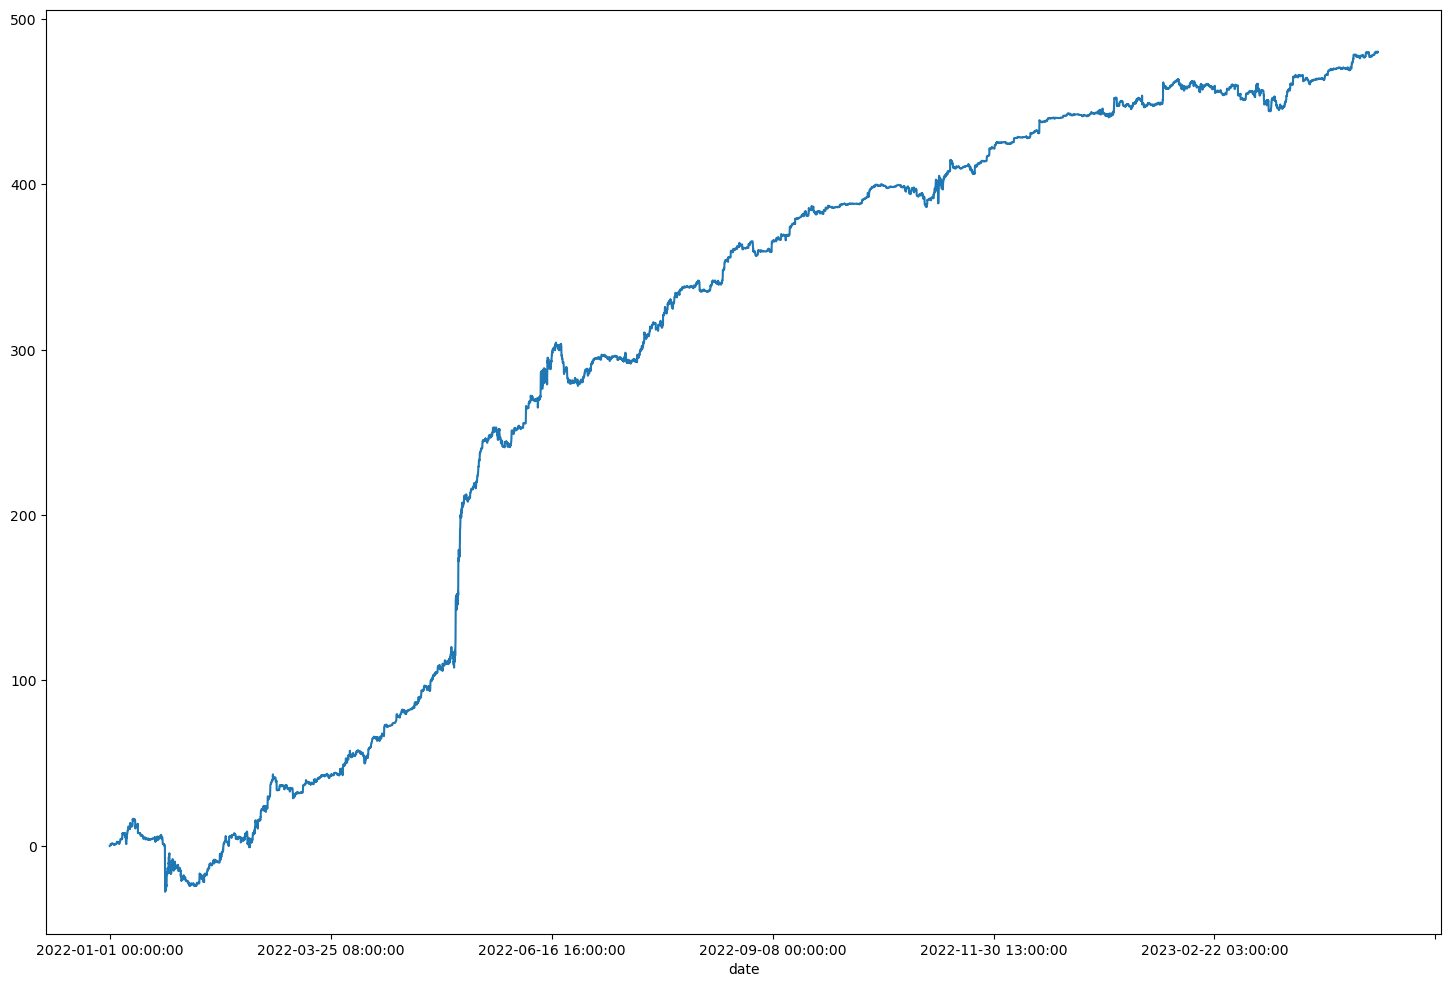

In [312]:
tfilters = (alldata.date > '2022') & alldata.inuniv & (alldata['zperf_seas1'].abs()>0.01)
print(sum(tfilters))
alldata[tfilters].groupby('date').apply(lambda x: (-x['zperf_seas1'] / x['vol'] * x['zperf']).sum()).cumsum().plot(figsize=(18,12))

In [374]:
alldata['sig'] = -alldata['zperf_seas1'] / alldata['vol']
pnl = alldata[tfilters].groupby('date').apply(lambda x: (x['sig'] * x['zperf']).sum())
gmv = alldata[tfilters].groupby('date').apply(lambda x: x['sig'].abs().sum())
gfun_df(f'abs_sig_diff', alldata, 'sig', 'symbol', lambda x: x.diff().abs())

In [375]:
abs_wt_chg = alldata[tfilters].groupby('date').apply(lambda x: x['abs_sig_diff'].sum())

In [380]:
retptrade = pnl.sum() / abs_wt_chg.sum()

In [381]:
retptrade

0.000687166809218896

In [379]:
pnl.mean()

0.012486425624868808

In [370]:
cost = alldata[tfilters].groupby('date').apply(lambda x: x['sig_diff'].abs().sum()) * 0.0002
pnl_pct = ((pnl-cost) / gmv).replace([np.inf, -np.inf], np.nan)

In [288]:
cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=xrank(alldata['zperf_seas5'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5])

,mygroup,cnt,vol,adv,med_zperf_seas5,min_zperf_seas5,max_zperf_seas5,0,1,2,3,5
0,0.0,213231,0.013904,183663.178724,-0.008619,-2.090335e-01,-0.006063,0.000469,0.000273,0.000151,0.000162,0.000218
1,1.0,213230,0.010960,141857.521878,-0.004604,-6.062666e-03,-0.003568,0.000009,0.000163,0.000115,0.000094,0.000142
2,2.0,213230,0.009901,125626.135400,-0.002757,-3.568181e-03,-0.002076,-0.000030,0.000078,-0.000010,0.000005,-0.000027
3,3.0,213230,0.009283,113270.772894,-0.001482,-2.076281e-03,-0.000948,-0.000057,0.000029,0.000019,0.000045,-0.000016
4,4.0,213877,0.008774,104486.405038,-0.000457,-9.479417e-04,0.000000,-0.000047,0.000034,0.000058,0.000100,-0.000018
5,5.0,212584,0.008724,101550.688351,0.000441,6.938894e-19,0.000918,-0.000100,-0.000026,-0.000035,-0.000046,-0.000078
6,6.0,213230,0.009149,114849.640995,0.001432,9.176786e-04,0.001995,-0.000067,-0.000111,-0.000053,-0.000085,-0.000197
7,7.0,213230,0.009727,124039.491133,0.002639,1.995325e-03,0.003408,-0.000105,-0.000121,-0.000162,-0.000280,-0.000429
8,8.0,213230,0.010790,141987.850018,0.004392,3.408316e-03,0.005789,-0.000108,-0.000192,-0.000279,-0.000467,-0.000643
9,9.0,213231,0.013880,207681.113008,0.008318,5.789258e-03,0.822654,-0.000331,-0.000492,-0.000581,-0.000763,-0.001127


In [293]:
gfun_df('alpha_zperf_seas3', alldata, 'tmp', 'date', lambda x: rerank(x), tgt_arr=alldata['zperf_seas3'], cond=alldata.inuniv)
gfun_df('alpha_zperf_seas5', alldata, 'tmp', 'date', lambda x: rerank(x), tgt_arr=alldata['zperf_seas5'], cond=alldata.inuniv)

In [42]:
def pnldetails(alldata, wtcol):
    if not 'year' in alldata.columns:
        alldata['year'] = np.floor(alldata['data_date'] / 1e4).astype(int)
    alldata['tmp'] = alldata[wtcol]
    alldata[wtcol] = alldata[wtcol] * (alldata.in_trading_universe=='Y')
    alldata['abs_wt'] = np.abs(alldata[wtcol])
    gfun_df('abs_wt_chg', alldata, wtcol, alldata.security_id, lambda x: np.abs(x.fillna(0).diff()))
    abs_wt_chg_day = alldata.groupby('data_date')['abs_wt_chg'].sum().rename('abs_wt_chg')
    # calculate PnL
    alldata['spnl'] = alldata[wtcol] * alldata['fsret_1d']
    gmv_day = alldata.groupby('data_date')['abs_wt'].sum().rename('gmv')
    gmv_day = (gmv_day + gmv_day.shift(1)).replace(0,np.nan) / 2
    spnl_day = alldata.groupby('data_date')['spnl'].sum().rename('spnl')
    spnl_day_pct = (spnl_day / gmv_day.replace(0,np.nan)).rename('spnl(%)')
    spnl_day_ac_pct = ((spnl_day - abs_wt_chg_day * 1e-4) / gmv_day.replace(0,np.nan)).rename('spnl_ac(%)')
    alldata['pnl'] = alldata[wtcol] * alldata['fret_1d']
    pnl_day = alldata.groupby('data_date')['pnl'].sum().rename('pnl')
    pnl_day_pct = (pnl_day / gmv_day.replace(0,np.nan)).rename('pnl(%)')
    pnl_day_ac_pct = ((pnl_day - abs_wt_chg_day * 1e-4) / gmv_day.replace(0,np.nan)).rename('pnl_ac(%)')
    
    turnover_day = (abs_wt_chg_day / gmv_day).rename('turnover')
    tab_daily = pd.concat([gmv_day, turnover_day, spnl_day, spnl_day_pct, spnl_day_ac_pct, pnl_day, pnl_day_pct, pnl_day_ac_pct, abs_wt_chg_day], axis = 1)
    tab_daily.index = tab_daily.index.astype(str)
    tab_daily['year'] = tab_daily.index.str[:4]
    tab_year = pd.concat([tab_daily.groupby('year')[['gmv', 'turnover']].mean(), tab_daily.groupby('year')[['spnl(%)', 'pnl(%)', 'spnl_ac(%)', 'pnl_ac(%)']].sum() * 100], axis=1)
    tab_year['sretptrade'] = tab_daily.groupby('year')['spnl'].sum() / tab_daily.groupby('year')['abs_wt_chg'].sum() * 1e4
    tab_year['retptrade'] = tab_daily.groupby('year')['pnl'].sum() / tab_daily.groupby('year')['abs_wt_chg'].sum() * 1e4
    tab_year['sSR'] = tab_daily.groupby('year')['spnl(%)'].mean() / tab_daily.groupby('year')['spnl(%)'].std() * np.sqrt(252)
    tab_year['SR'] = tab_daily.groupby('year')['pnl(%)'].mean() / tab_daily.groupby('year')['pnl(%)'].std() * np.sqrt(252)
    tab_year['sSR_ac'] = tab_daily.groupby('year')['spnl_ac(%)'].mean() / tab_daily.groupby('year')['spnl_ac(%)'].std() * np.sqrt(252)
    tab_year['SR_ac'] = tab_daily.groupby('year')['pnl_ac(%)'].mean() / tab_daily.groupby('year')['pnl_ac(%)'].std() * np.sqrt(252)
    tab_year.loc['summary'] = [tab_daily['gmv'].mean(), 
                               tab_daily['turnover'].mean(), 
                               tab_daily['spnl(%)'].mean() * 252 * 100,
                               tab_daily['pnl(%)'].mean() * 252 * 100, 
                               tab_daily['spnl_ac(%)'].mean() * 252 * 100,
                               tab_daily['pnl_ac(%)'].mean() * 252 * 100, 
                               tab_daily['spnl'].sum() / tab_daily['abs_wt_chg'].sum() * 1e4,
                               tab_daily['pnl'].sum() / tab_daily['abs_wt_chg'].sum() * 1e4,
                               tab_daily['spnl(%)'].mean() / tab_daily['spnl(%)'].std() * np.sqrt(252),
                               tab_daily['pnl(%)'].mean() / tab_daily['pnl(%)'].std() * np.sqrt(252),
                               tab_daily['spnl_ac(%)'].mean() / tab_daily['spnl_ac(%)'].std() * np.sqrt(252),
                               tab_daily['pnl_ac(%)'].mean() / tab_daily['pnl_ac(%)'].std() * np.sqrt(252)]
    avg_pos_wt = (alldata[alldata[wtcol]>0].groupby('data_date')[wtcol].sum()).mean()
    avg_neg_wt = (alldata[alldata[wtcol]<0].groupby('data_date')[wtcol].sum()).mean()
    print(f'avg positive weight: {avg_pos_wt}')
    print(f'avg negative weight: {avg_neg_wt}')

    tab_year = round(tab_year.fillna(0), 2)
    display(HTML(tab_year.to_html()))
    tab_daily['fpnl(%)'] = tab_daily['pnl_ac(%)'] - tab_daily['spnl_ac(%)']
    tab_daily['pnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "red", figsize = (15,6))
    tab_daily['spnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "green", figsize = (15,6))
    tab_daily['fpnl(%)'].fillna(0).cumsum().plot(title = "PnL", color = "blue", figsize = (15,6))
    plt.gca().legend(("pnl_ac", "spnl_ac", "fpnl"))
    return

In [43]:
def getmaxdd(pnls):
    cumpnl = pnls.cumsum()
    maxdd = 0
    maxdd_sidx = -1
    maxdd_eidx = -1
    currhigh = 0
    currlow = 0
    currdd_sidx = -1
    currdd_eidx = -1
    currdd = 0
    for i in range(len(pnls)):
        if cumpnl.iloc[i] > currhigh:
            if currdd < maxdd:
                maxdd_sidx = currdd_sidx+1
                maxdd_eidx = i-1
                maxdd = currdd
            currdd = 0
            currhigh = cumpnl.iloc[i]
            currlow = cumpnl.iloc[i]
            currdd_sidx = i
        elif cumpnl.iloc[i] < currlow:
            currdd = cumpnl[i] - currhigh
            currlow = cumpnl[i]
            currdd_eidx = i
    if currdd < maxdd:
        maxdd_sidx = currdd_sidx
        maxdd_eidx = len(pnls)-1
        maxdd = currdd
    return maxdd, pnls.index[maxdd_sidx], pnls.index[maxdd_eidx]

In [44]:
def pnldetails_portfolio(alldata, wtcol, tcost=1e-4):
    if not 'year' in alldata.columns:
        alldata['year'] = np.floor(alldata['data_date'] / 1e4).astype(int)
    alldata['tmp'] = alldata[wtcol]
    alldata[wtcol] = alldata[wtcol] * (alldata.in_trading_universe=='Y')
    alldata['abs_wt'] = np.abs(alldata[wtcol])
    gfun_df('abs_wt_chg', alldata, wtcol, alldata.security_id, lambda x: np.abs(x.fillna(0).diff()))
    abs_wt_chg_day = alldata.groupby('data_date')['abs_wt_chg'].sum().rename('abs_wt_chg')
    # calculate PnL
    alldata['spnl'] = alldata[wtcol] * alldata['fsret_1d']
    gmv_day = alldata.groupby('data_date')['abs_wt'].sum().rename('gmv')
    alldata['pnl'] = alldata[wtcol] * alldata['fret_1d']
    pnl_day = alldata.groupby('data_date')['pnl'].sum().rename('pnl')
    pnl_day_pct = (pnl_day / gmv_day.replace(0,np.nan)).rename('pnl(%)')
    pnl_day_ac_pct = ((pnl_day - abs_wt_chg_day * tcost) / gmv_day.replace(0,np.nan)).rename('pnl_ac(%)')
    
    turnover_day = (abs_wt_chg_day / gmv_day).rename('turnover')
    tab_daily = pd.concat([gmv_day, turnover_day, pnl_day, pnl_day_pct, pnl_day_ac_pct, abs_wt_chg_day], axis = 1)
    tab_daily.index = tab_daily.index.astype(str)
    tab_daily['year'] = tab_daily.index.str[:4]
    tab_daily['neg_pnl_ac(%)'] = tab_daily['pnl_ac(%)'] * (tab_daily['pnl_ac(%)'] < 0)
    tab_year = pd.concat([tab_daily.groupby('year')[['gmv', 'turnover']].mean(), tab_daily.groupby('year')[['pnl(%)', 'pnl_ac(%)']].sum() * 100], axis=1)
    tab_year['retptrade'] = tab_daily.groupby('year')['pnl'].sum() / tab_daily.groupby('year')['abs_wt_chg'].sum() * 1e4
    tab_year['annvol'] = tab_daily.groupby('year')['pnl(%)'].std() * np.sqrt(252)
    tab_year['SR'] = tab_daily.groupby('year')['pnl(%)'].mean() / tab_daily.groupby('year')['pnl(%)'].std() * np.sqrt(252)
    tab_year['SR_ac'] = tab_daily.groupby('year')['pnl_ac(%)'].mean() / tab_daily.groupby('year')['pnl_ac(%)'].std() * np.sqrt(252)
    tab_year['Sortino_ac'] = tab_daily.groupby('year')['pnl_ac(%)'].mean() / tab_daily.groupby('year')['neg_pnl_ac(%)'].std() * np.sqrt(252)
    tab_year.loc['summary'] = [tab_daily['gmv'].mean(), 
                               tab_daily['turnover'].mean(),
                               tab_daily['pnl(%)'].mean() * 252 * 100,
                               tab_daily['pnl_ac(%)'].mean() * 252 * 100,
                               tab_daily['pnl'].sum() / tab_daily['abs_wt_chg'].sum() * 1e4,
                               tab_daily['pnl(%)'].std() * np.sqrt(252),
                               tab_daily['pnl(%)'].mean() / tab_daily['pnl(%)'].std() * np.sqrt(252),
                               tab_daily['pnl_ac(%)'].mean() / tab_daily['pnl_ac(%)'].std() * np.sqrt(252),
                               tab_daily['pnl_ac(%)'].mean() / tab_daily['neg_pnl_ac(%)'].std() * np.sqrt(252)]
    print('tab_year generated')
    maxdd, maxdd_sdate, maxdd_edate = getmaxdd(tab_daily['pnl_ac(%)'])
    maxdd = round(maxdd*100, 2)
    print(f'maxdd: {maxdd}%')
    print(f'start date of maxdd: {maxdd_sdate}')
    print(f'end date of maxdd: {maxdd_edate}')
    hitrate = round(sum(tab_daily['pnl_ac(%)']>0)/len(tab_daily['pnl_ac(%)']), 2)
    print(f'% of positive days: {hitrate}')
    alldata[wtcol] = alldata['tmp']

    tab_year = round(tab_year.fillna(0), 2)
    display(HTML(tab_year.to_html()))
    tab_daily['pnl(%)'].fillna(0).cumsum().plot(title = "PnL", color = "red", figsize = (15,6))
    tab_daily['pnl_ac(%)'].fillna(0).cumsum().plot(title = "PnL", color = "purple", figsize = (15,6))
    plt.gca().legend(("pnl", "pnl(after cost)"))
    return

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def cgma(df, 
         gb,
         wtcol='',
         cn=[], 
         rmod='fperf',
         ofun_dict={},
         ret_ds=[]):
    zip_flag = False
    if not type(gb) in (list, str):
        gname = gb.name
        if gname in df.columns:
            if df[gname].dtype == float:
                ofun_dict.update({
                    ('med_'+gname):lambda df: df[gname].median(),
                    ('min_'+gname):lambda df: df[gname].min(),
                    ('max_'+gname):lambda df: df[gname].max()
                })
                cn = cn + ['med_'+gname, 'min_'+gname, 'max_'+gname]
        gb = gb.rename('mygroup')
    if wtcol=='':
        df.loc[:,'ones'] = 1
        wtcol = 'ones'
    res_tab = df.groupby(gb).apply(multi_analysis, wtcol, cn, ofun_dict, rmod, ret_ds)
    if wtcol == 'ones':
        df = df.drop(columns=['ones'])
    index_cols = [i for i in list(res_tab.index.names) if i]
    res_tab = res_tab.reset_index()
    del res_tab['level_1']
    res_tab.set_index(index_cols)
    return res_tab

In [277]:
def multi_analysis(df, 
                   wtcol='',
                   cn=[], 
                   ofun_dict={}, 
                   rmod='fperf', 
                   ret_ds=[1,3,5,10,15,20]):
    basic_fun_dict = {'cnt': lambda df: len(df), 'vol': lambda df: df['vol'].median(), 'adv': lambda df: df['adv'].median()}
    basic_fun_dict.update(ofun_dict)
    keys = []
    ress = []
    for c in cn:
        if c in basic_fun_dict:
            keys.append(c)
            ress.append((basic_fun_dict[c])(df))
        elif c in df.columns:
            keys.append('med_'+c)
            ress.append(df[c].median())
            keys.append('min_'+c)
            ress.append(df[c].min())
            keys.append('max_'+c)
            ress.append(df[c].max())
    if len(ret_ds) > 0:
        for nd in ret_ds:
            keys.append(nd)
            if nd == 0:
                ret = np.nansum(df['zperf'].clip(-0.5,0.5) * df[wtcol].abs()) / np.nansum(df[wtcol].abs())
            else:
                ret = np.nansum(df[rmod+'_'+str(nd)].clip(-0.5,0.5) * df[wtcol].abs()) / np.nansum(df[wtcol].abs())
            ress.append(ret)
    return pd.DataFrame({keys[i]:[ress[i]] for i in range(len(keys))})